In [1]:
## Choose GPUs and CPUs

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

GPU=True
CPU=False

if GPU:
    num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(','))
    num_CPU = 8
if CPU:
    num_CPU = 16
    num_GPU = 0

config = tf.ConfigProto(#intra_op_parallelism_threads=num_cores,\
#        inter_op_parallelism_threads=num_cores, 
#        allow_soft_placement=True,\
#        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
config.gpu_options.allow_growth=True 
session = tf.Session(config=config)
K.set_session(session)



Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize

In [3]:
h,w=64,64
nepochs=75
wt_path = 'wts4'
batch_size = 32

if (not os.path.isdir(wt_path)):
    os.mkdir(wt_path)

### Read training data

In [4]:
data_diffr = np.load('../expt_data/s26_data/20191008_39_diff.npz')['arr_0']

(161, 161, 256, 256)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


W0324 00:40:29.682266 140597338761024 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


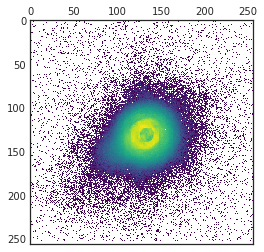

In [5]:
print(data_diffr.shape)
plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


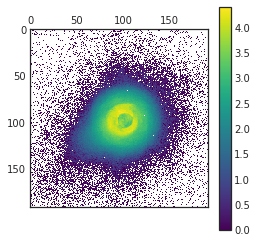

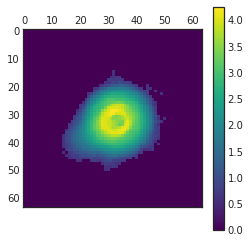

In [6]:
plt.matshow(np.log10(data_diffr[0,0,32:-32,32:-32]))
plt.colorbar()
plt.matshow(np.log10(data_diffr_red[0,0]+1))
plt.colorbar()

In [7]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load('../expt_data/s26_data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

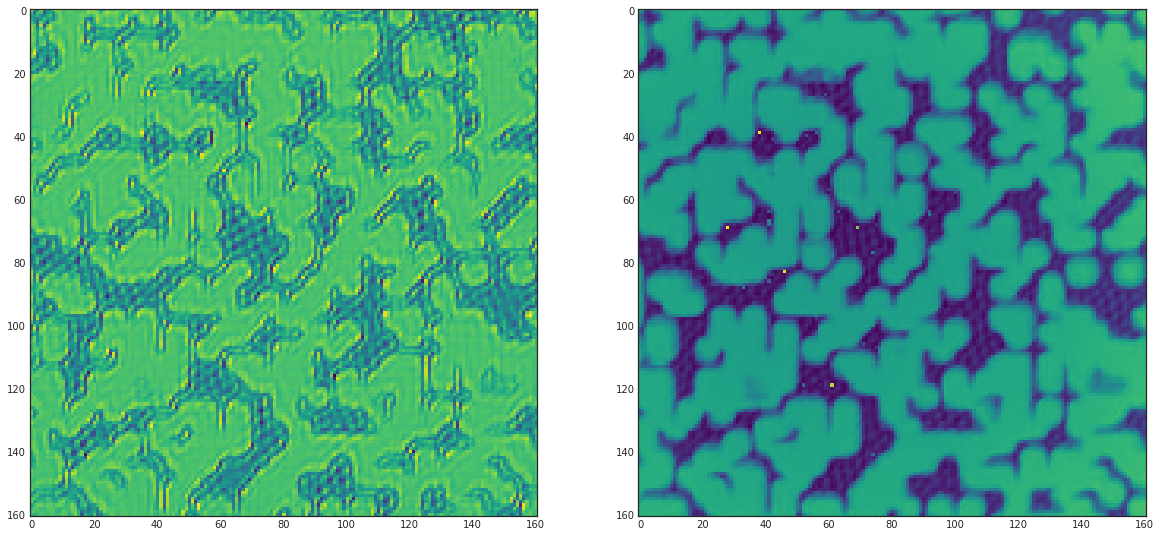

In [8]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [9]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [10]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)
#X_train, X_test, Y_I_train, Y_I_test, Y_phi_train, Y_phi_test = \
#    train_test_split(X_data, Y_I_data, Y_phi_data, test_size=0.05, shuffle=False)


#DO NOT SHUFFLE CAUSE NEED

(16100, 64, 64, 1) (3600, 64, 64, 1)


# Autoencoder-structure predictor

In [11]:

K.clear_session()
np.random.seed(123)
model=Sequential()

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)


input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
#Activations are all ReLu

encoded=x

#Decoding arm 1
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


#Decoding arm 2
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

#Put together
autoencoder = Model(input_img, [decoded1, decoded2])
parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
parallel_model.compile(optimizer='adam', loss='mean_absolute_error')

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')


W0324 00:40:35.469500 140597338761024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0324 00:40:35.470855 140597338761024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0324 00:40:35.475213 140597338761024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0324 00:40:35.504593 140597338761024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W032

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

checkpoints=keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Train on 15295 samples, validate on 805 samples
Epoch 1/75
15295/15295 [==============================] - 15s 974us/step - loss: 0.6845 - conv2d_13_loss: 0.0408 - conv2d_20_loss: 0.6437 - val_loss: 0.4865 - val_conv2d_13_loss: 0.0076 - val_conv2d_20_loss: 0.4789

Epoch 00001: val_loss improved from inf to 0.48652, saving model to wts4/weights.01.hdf5
Epoch 2/75
15295/15295 [==============================] - 12s 778us/step - loss: 0.4579 - conv2d_13_loss: 0.0074 - conv2d_20_loss: 0.4506 - val_loss: 0.4338 - val_conv2d_13_loss: 0.0069 - val_conv2d_20_loss: 0.4268

Epoch 00002: val_loss improved from 0.48652 to 0.43377, saving model to wts4/weights.02.hdf5
Epoch 3/75
15295/15295 [==============================] - 12s 781us/step - loss: 0.3977 - conv2d_13_loss: 0.0068 - conv2d_20_loss: 0.3909 - val_loss: 0.3742 - val_conv2d_13_loss: 0.0065 - val_conv2d_20_loss: 0.3676

Epoch 00003: val_loss improved from 0.43377 to 0.37416, saving model to wts4/weights.03.hdf5
Epoch 4/75
15295/15295 [=====


Epoch 00027: val_loss improved from 0.19603 to 0.19320, saving model to wts4/weights.27.hdf5
Epoch 28/75
15295/15295 [==============================] - 11s 711us/step - loss: 0.1698 - conv2d_13_loss: 0.0052 - conv2d_20_loss: 0.1646 - val_loss: 0.1928 - val_conv2d_13_loss: 0.0054 - val_conv2d_20_loss: 0.1875

Epoch 00028: val_loss improved from 0.19320 to 0.19284, saving model to wts4/weights.28.hdf5
Epoch 29/75
15295/15295 [==============================] - 11s 708us/step - loss: 0.1660 - conv2d_13_loss: 0.0051 - conv2d_20_loss: 0.1608 - val_loss: 0.1875 - val_conv2d_13_loss: 0.0053 - val_conv2d_20_loss: 0.1822

Epoch 00029: val_loss improved from 0.19284 to 0.18748, saving model to wts4/weights.29.hdf5
Epoch 30/75
15295/15295 [==============================] - 11s 715us/step - loss: 0.1649 - conv2d_13_loss: 0.0051 - conv2d_20_loss: 0.1598 - val_loss: 0.1882 - val_conv2d_13_loss: 0.0053 - val_conv2d_20_loss: 0.1829

Epoch 00030: val_loss did not improve from 0.18748
Epoch 31/75
15295/


Epoch 00054: val_loss improved from 0.13674 to 0.13451, saving model to wts4/weights.54.hdf5
Epoch 55/75
15295/15295 [==============================] - 11s 689us/step - loss: 0.0867 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0829 - val_loss: 0.1345 - val_conv2d_13_loss: 0.0046 - val_conv2d_20_loss: 0.1298

Epoch 00055: val_loss improved from 0.13451 to 0.13448, saving model to wts4/weights.55.hdf5
Epoch 56/75
15295/15295 [==============================] - 11s 691us/step - loss: 0.0860 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0822 - val_loss: 0.1346 - val_conv2d_13_loss: 0.0046 - val_conv2d_20_loss: 0.1300

Epoch 00056: val_loss did not improve from 0.13448

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 57/75
15295/15295 [==============================] - 10s 682us/step - loss: 0.0848 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0811 - val_loss: 0.1342 - val_conv2d_13_loss: 0.0046 - val_conv2d_20_loss: 0.1295

Epoch 00057: val_loss improved from 0.13448 t

W0324 00:54:24.115716 140597338761024 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


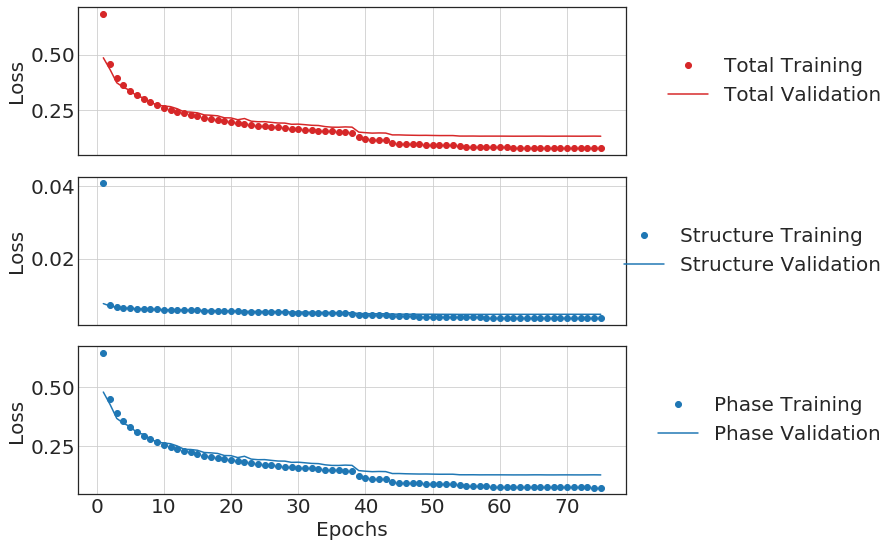

In [13]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['conv2d_13_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_conv2d_13_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['conv2d_20_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_conv2d_20_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [14]:
np.save('str_history', history.history)

In [15]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save('%s/min_epoch' %(wt_path), min_epoch)

68


In [16]:
min_epoch = np.load('%s/min_epoch.npy' %wt_path)
from keras.models import Model, load_model
model=load_model('%s/weights.%02d.hdf5' %(wt_path,min_epoch))
#score=model.evaluate(ft_test, test_dataset, verbose=1)
#print (score)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
preds_intens=(model.predict(X_test))
print (preds_intens[0].shape)

(3600, 64, 64, 1)


In [18]:
#preds_intens=np.where(preds_intens<0.1,0,preds_intens)

# Plot some instances of the test data, it's FT and the CNN prediction

<Figure size 432x288 with 0 Axes>

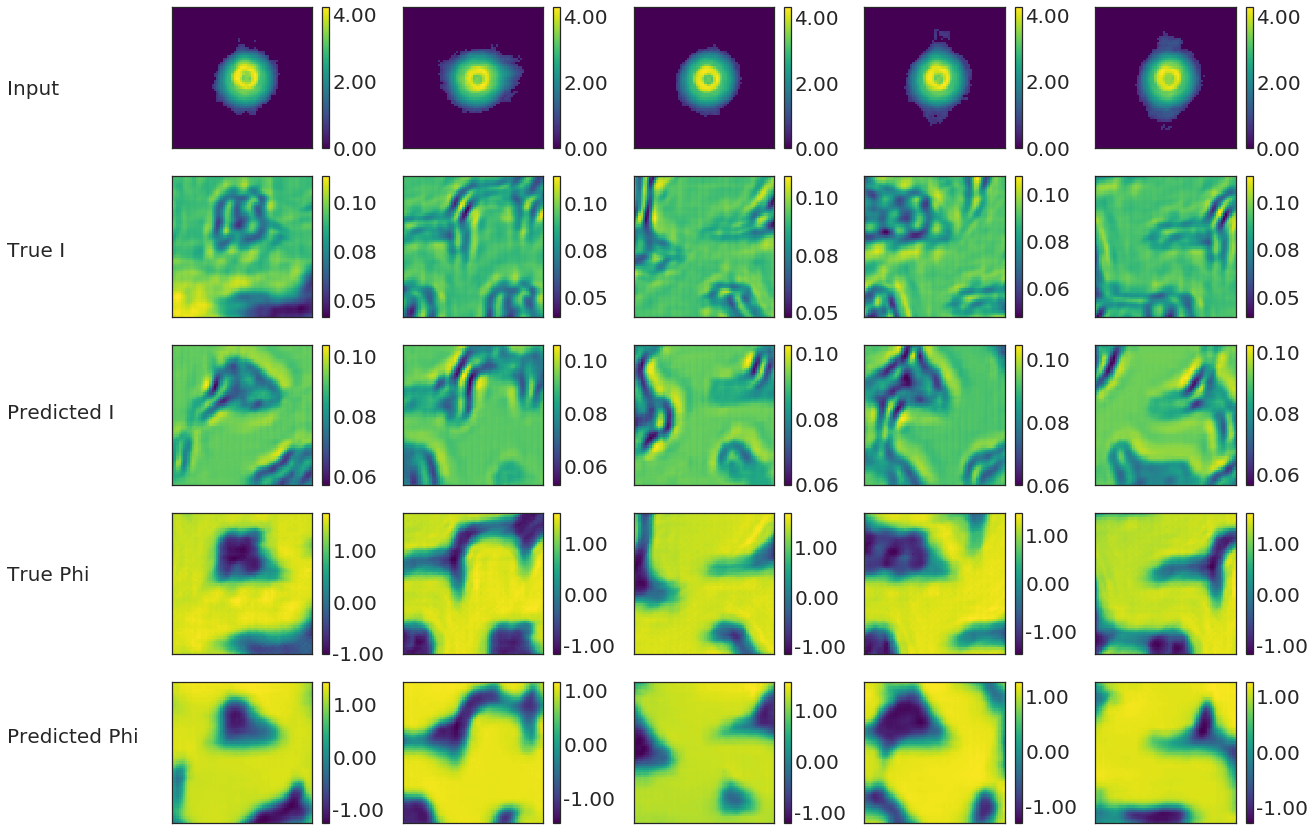

In [19]:
ntest=preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(5,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.8, "Input", fontsize=20)
plt.gcf().text(0.02, 0.65, "True I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.35, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.2, "Predicted Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

        # display FT
    im=ax[0,i].imshow(np.log10(X_test[j].reshape(h, w)+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_intens[0][j].reshape(h, w))
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
        # display original phase
    im=ax[3,i].imshow(Y_phi_test[j].reshape(h, w))
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[4,i].imshow(preds_intens[1][j].reshape(h, w))
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
plt.show()

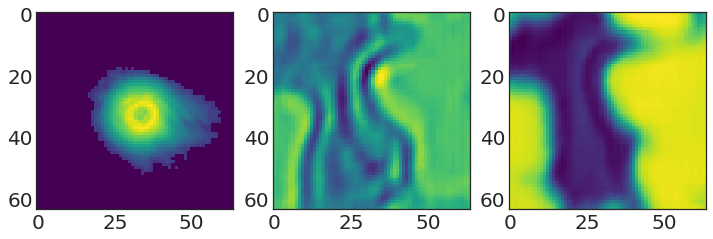

In [20]:
j=10
fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(np.log10(X_test[j].reshape(h, w)+1))
ax[1].imshow(preds_intens[0][j].reshape(h, w))
ax[2].imshow(preds_intens[1][j].reshape(h, w))

## Plot NN predictions 

In [21]:
tst_side = 60
tst_side

60

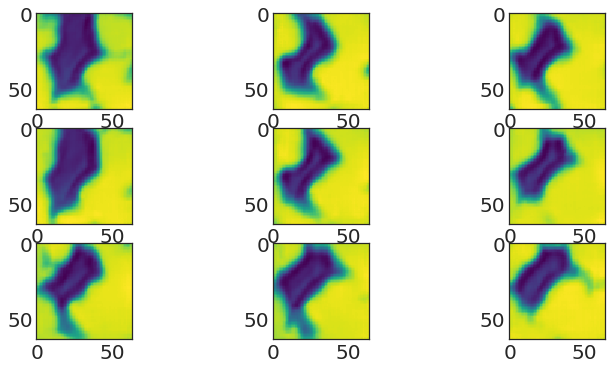

In [22]:
fig, ax = plt.subplots(3,3, figsize=(12,6))
ax[0,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,9]))
ax[0,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,10]))
ax[0,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[9,11]))
ax[1,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,9]))
ax[1,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,10]))
ax[1,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[10,11]))
ax[2,0].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,9]))
ax[2,1].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,10]))
ax[2,2].imshow((preds_intens[1].reshape(tst_side,tst_side,64,64)[11,11]))

In [23]:
point_size = 3
overlap = 4*point_size

In [24]:

composite_phase = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_phase)
data_reshaped = preds_intens[1].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_phase[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


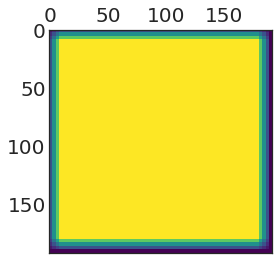

In [25]:
plt.matshow(ctr)

(-0.5, 179.5, 179.5, -0.5)

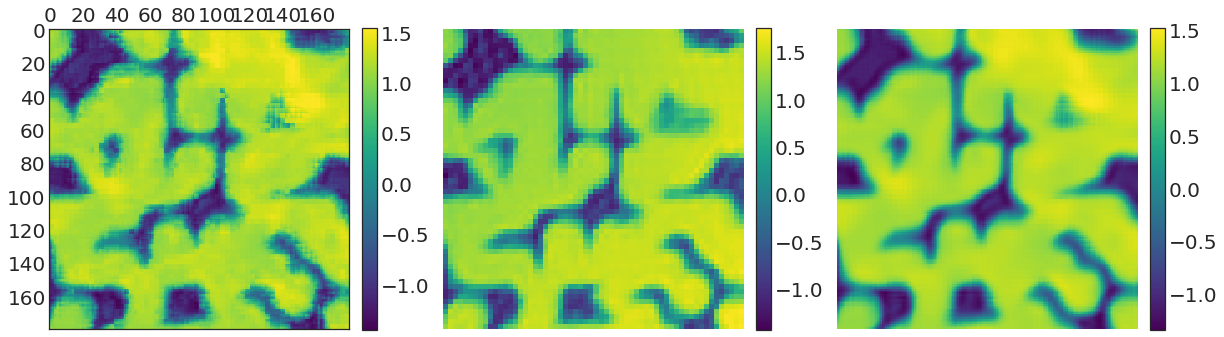

In [26]:
fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].matshow(np.transpose(preds_intens[1].reshape(tst_side,tst_side,64,64)
                         [:,:,31:34,31:34], (0,2,1,3)).reshape(tst_side*3,tst_side*3))
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
#plt.matshow(Y_phi_test.reshape(tst_side,tst_side,64,64)[int(tst_side/,10], vmin=-1, vmax=1.5)

im=ax[1].imshow(ph[tst_strt:,tst_strt:,32,32])
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')
im=ax[2].imshow(composite_phase[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)])
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

In [27]:

composite_amp = np.zeros((tst_side*point_size+overlap,tst_side*point_size+overlap),float)
ctr = np.zeros_like(composite_amp)
data_reshaped = preds_intens[0].reshape(tst_side,tst_side,64,64)[:,:,32-int(overlap/2):32+int(overlap/2),
                                                     32-int(overlap/2):32+int(overlap/2)]

for i in range(tst_side):
    for j in range(tst_side):
        composite_amp[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] += data_reshaped[i,j]
        ctr[point_size*i:point_size*i+overlap, point_size*j:point_size*j+overlap] +=1


(-0.5, 179.5, 179.5, -0.5)

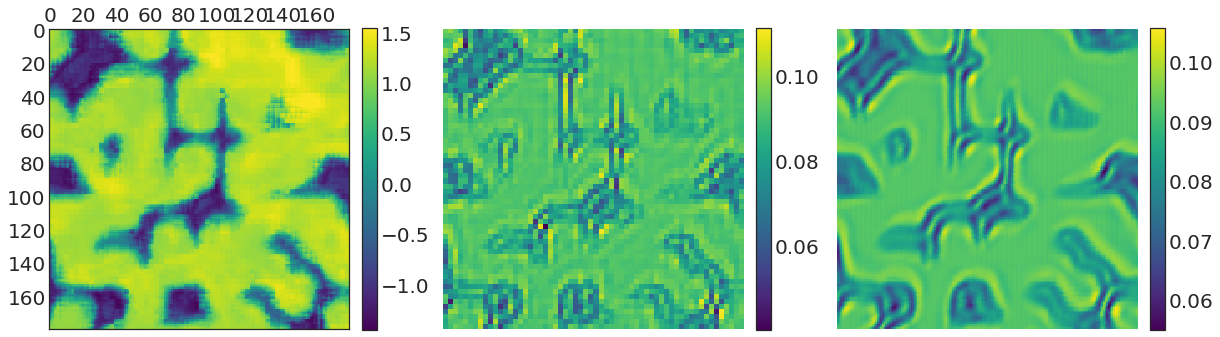

In [28]:
fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].matshow(np.transpose(preds_intens[1].reshape(tst_side,tst_side,64,64)
                         [:,:,31:34,31:34], (0,2,1,3)).reshape(tst_side*3,tst_side*3))
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
#plt.matshow(Y_phi_test.reshape(tst_side,tst_side,64,64)[int(tst_side/,10], vmin=-1, vmax=1.5)

im=ax[1].imshow(amp[tst_strt:,tst_strt:,32,32])
ax[1].axis('off')
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
im=ax[2].imshow(composite_amp[int(overlap/2):-int(overlap/2), int(overlap/2):-int(overlap/2)]/ctr[int(overlap/2)
                                                                    :-int(overlap/2), int(overlap/2):-int(overlap/2)])
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')